In [1]:
from galileojp.frames import ExperimentFrameGateway
from galileojp.external import concurrent_req_log_as_df
from galileojp.widgets import experiment_dropdown
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:

def id_by_name(name, filename):
    xp = ExperimentFrameGateway.from_file(filename).experiments()
    return xp[xp['NAME'] == name]['EXP_ID'].iloc[0]

In [3]:

def make_plot(host, title, base_df, conc_df):
    host.set_title(title)
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()

    host.set_ylim(0, 6)
    par1.set_ylim(0, 110)
    par2.set_ylim(0, 110)
    par3.set_ylim(0, 1000)

    host.set_xlabel("Time")
    host.set_ylabel("Concurrent Requests")
    par1.set_ylabel("CPU Utilization %")
    par2.set_ylabel("RAM Utilization %")
    par3.set_ylabel("Response Time")

    host.set_zorder(1000)
    host.patch.set_visible(False)
    par1.set_zorder(10)
    par2.set_zorder(10)
    par3.set_zorder(1)

    c1 = 'black'
    c2 = 'silver'
    c3 = 'tab:red'
    c4 = 'tab:blue'

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    p1, = host.plot(conc_df['timestamp'], conc_df['concurrent_clients'], color=c1, zorder=1000)
    p2, = par1.plot(base_df['sent'], base_df['cpu'], color=c3, zorder=2)
    p3, = par2.plot(base_df['sent'], base_df['ram'], color=c4, zorder=2)
    p4, = par3.plot(base_df['sent'], base_df['rtt'], color=c2, zorder=1)

    par1.spines['right'].set_position(('outward', 45))
    par2.spines['right'].set_position(('outward', 90))


    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
                     
    par2.xaxis.set_ticks([])
    par3.xaxis.set_ticks([])

    


### data files of the stepped workload evaluation experiments

In [4]:
base_filepath = '../data/stepped_workload_eval'
small_db_path = base_filepath + '/small/stepped_small.sqlite'
small_log_path = base_filepath + '/small/stepped_small.log'
medium_db_path = base_filepath + '/medium/stepped_medium.sqlite'
medium_log_path = base_filepath + '/medium/stepped_medium.log'
large_db_path = base_filepath + '/large/stepped_large.sqlite'
large_log_path = base_filepath + '/large/stepped_large.log'


In [5]:
# This function is simply used to convert the log of concurrent clients into something that visualizes well
# When looking at the raw data this should become obvious. There is simply a single timestamp that marks
# the number of active concurrent clients. This value is true until the next value is logged
# A typical visualisation plot would draw a straight line between the points, but since we don't interpolate in truth
# i.e. we don't have 1.5 concurrent clients, only 1 and later on 2, we need to change the data to make the plot accurate
def prepare_concurrent_client_df(filename, from_index, to_index, interval_seconds):
    df = concurrent_req_log_as_df(filename).loc[range(from_index, to_index)]
    df = df.append({ 'timestamp': df.loc[to_index - 1]['timestamp'] + pd.Timedelta(str(interval_seconds) + "s"), 'concurrent_clients': 5}, ignore_index=True)
    df = df.reset_index(drop=True)
    int_df = df.copy()
    i = 0
    lastval = 0
    for index, row in df.iterrows():
        if not i == 0:
            int_df = int_df.append({ "timestamp": row['timestamp'] - pd.Timedelta("1ns"), "concurrent_clients": lastval}, ignore_index=True)
        i += 1
        lastval = row['concurrent_clients']
    int_df = int_df.sort_values(by=['timestamp'])
    int_df = int_df.reset_index(drop=True)
    return int_df
       

slog_pdf = prepare_concurrent_client_df(small_log_path, 0, 5, 90)
slog_mx = prepare_concurrent_client_df(small_log_path, 5, 10, 90)
slog_euler = prepare_concurrent_client_df(small_log_path, 10, 15, 90)

mlog_pdf = prepare_concurrent_client_df(medium_log_path, 0, 5, 90)
mlog_mx = prepare_concurrent_client_df(medium_log_path, 5, 10, 90)
mlog_euler = prepare_concurrent_client_df(medium_log_path, 10, 15, 90)

llog_pdf = prepare_concurrent_client_df(large_log_path, 0, 5, 90)
llog_mx = prepare_concurrent_client_df(large_log_path, 5, 10, 90)
llog_euler = prepare_concurrent_client_df(large_log_path, 10, 15, 90)


In [6]:
max_ram_s = 1986232
max_ram_m = 3932244
max_ram_l = 16010912

def prepare_experiment_df(filename, experiment_name, max_ram, samples=1000):
    gw = ExperimentFrameGateway.from_file(filename)
    df = gw.traces_with_telemetry(id_by_name(experiment_name, filename))
    df = df[df['node'] == 'w1']
    df['ram'] = df['ram'].apply(lambda r: (r / max_ram) * 100)
    return df.sample(n=samples).sort_values(by=['sent'])
    
    
strac_pdf = prepare_experiment_df(small_db_path, 'pdf_stepped_s', max_ram_s)
strac_mx = prepare_experiment_df(small_db_path, 'mx_stepped_s', max_ram_s)
strac_euler = prepare_experiment_df(small_db_path, 'euler_stepped_s', max_ram_s)

mtrac_pdf = prepare_experiment_df(medium_db_path, 'pdf_stepped_m', max_ram_m)
mtrac_mx = prepare_experiment_df(medium_db_path, 'mx_stepped_m', max_ram_m)
mtrac_euler = prepare_experiment_df(medium_db_path, 'euler_stepped_m', max_ram_m)

ltrac_pdf = prepare_experiment_df(large_db_path, 'pdf_stepped_l', max_ram_l)
ltrac_mx = prepare_experiment_df(large_db_path, 'mx_stepped_l', max_ram_l)
ltrac_euler = prepare_experiment_df(large_db_path, 'euler_stepped_l', max_ram_l)

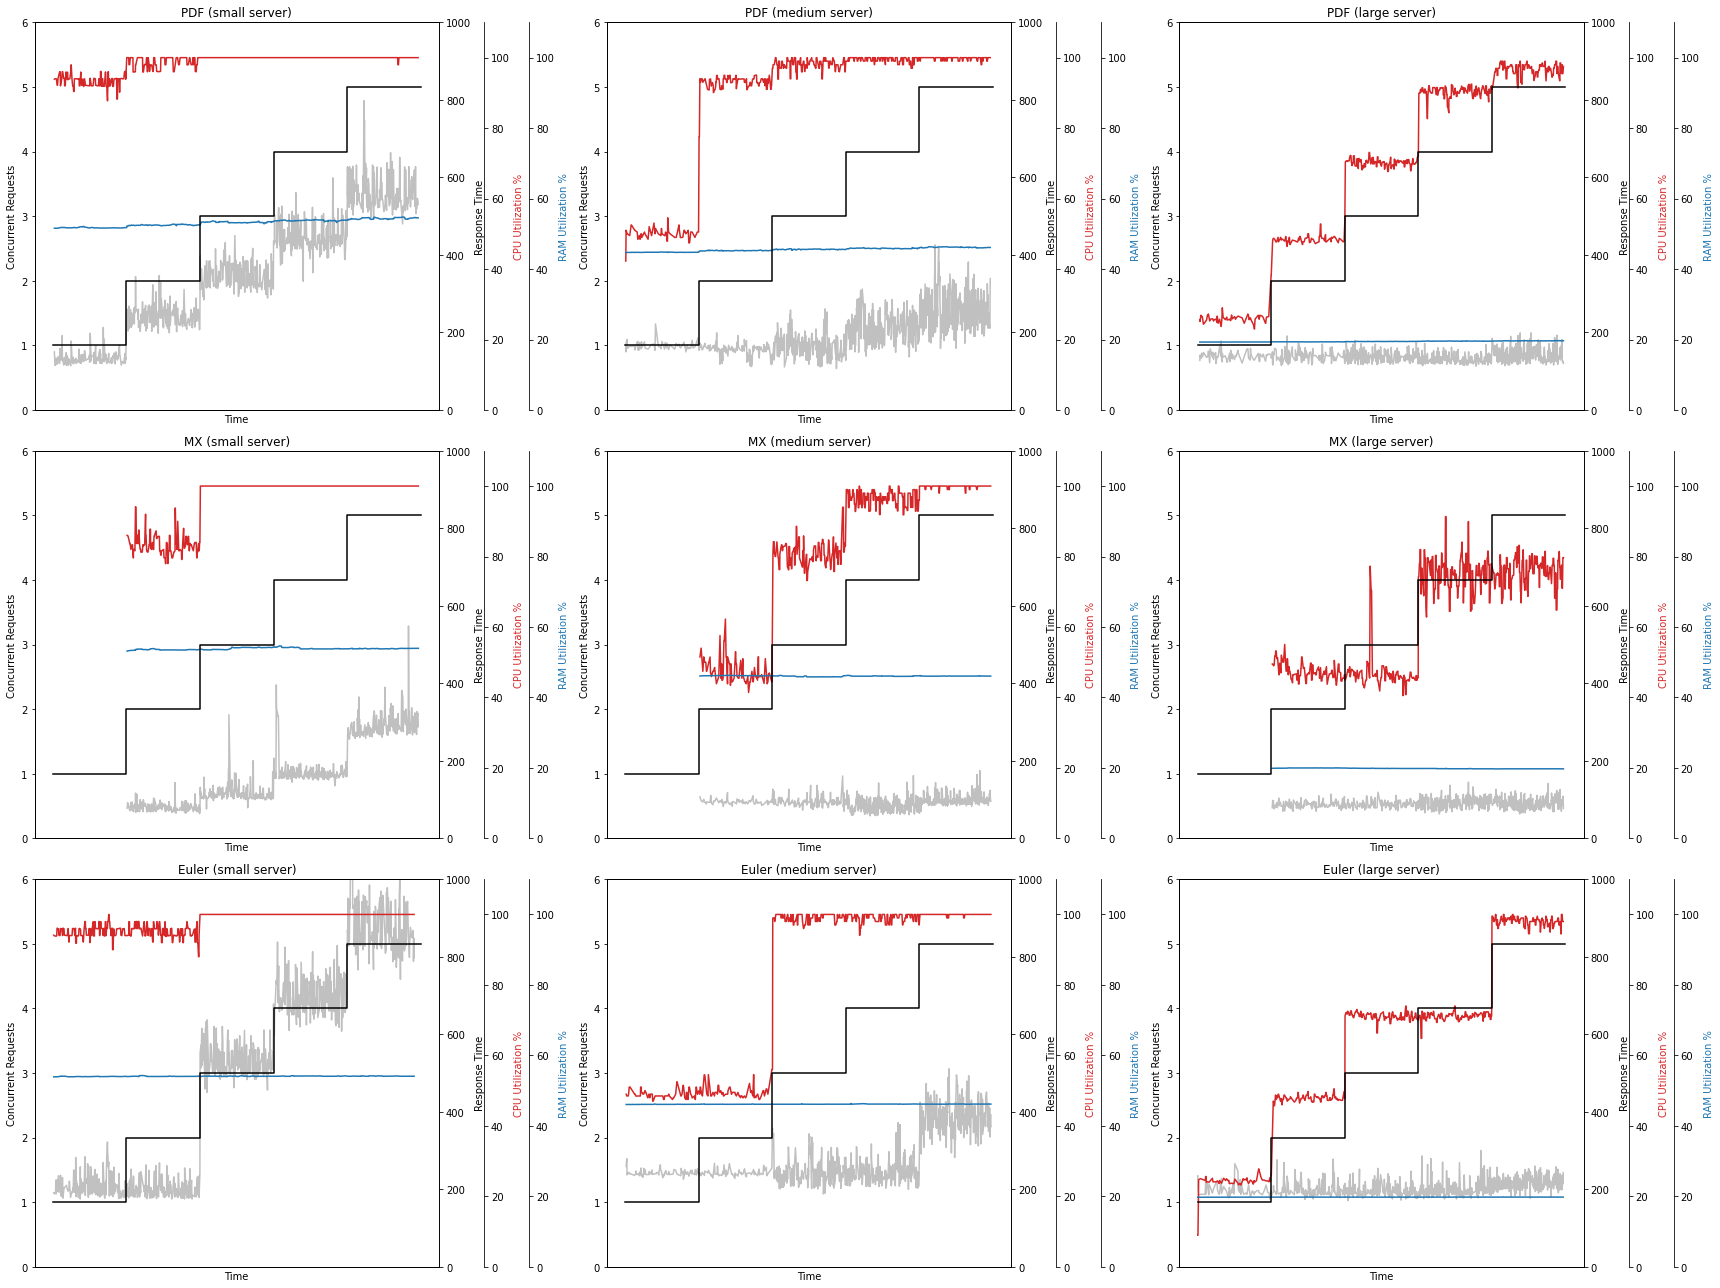

In [8]:
fig, hosts = plt.subplots(3, 3, figsize=(24,18))
s_pdf_host, m_pdf_host, l_pdf_host = hosts[0]
s_mx_host, m_mx_host, l_mx_host = hosts[1]
s_euler_host, m_euler_host, l_euler_host = hosts[2]


make_plot(s_pdf_host, 'PDF (small server)', strac_pdf, slog_pdf)
make_plot(m_pdf_host, 'PDF (medium server)', mtrac_pdf, mlog_pdf)
make_plot(l_pdf_host, 'PDF (large server)', ltrac_pdf, llog_pdf)

make_plot(s_mx_host, 'MX (small server)', strac_mx, slog_mx)
make_plot(m_mx_host, 'MX (medium server)', mtrac_mx, mlog_mx)
make_plot(l_mx_host, 'MX (large server)', ltrac_mx, llog_mx)

make_plot(s_euler_host, 'Euler (small server)', strac_euler, slog_euler)
make_plot(m_euler_host, 'Euler (medium server)', mtrac_euler,mlog_euler)
make_plot(l_euler_host, 'Euler (large server)', ltrac_euler, llog_euler)

fig.tight_layout()